# Automobile Data Price Prediction

This is a exercise notebook about EDA, Lineer Regression, Regulization, Futute Engineerin and more.

Data include automobile data such as engine, wheel, price etc.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
df =pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', header=None)

columns= ['symboling','normalized_losses','make','fuel_type',
          'aspiration','num_of_doors','body_style','drive_wheels',
          'engine_location','wheel_base','length','width','height',
          'curb_weight','engine_type','num_of_cylinders','engine_size',
          'fuel_system','bore','stroke','compression_ratio','horsepower',
          'peak_rpm','city_mpg','highway_mpg','price']
df.columns=columns

In [6]:
df.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


We have some some bad values like  '?', it needs replace

In [4]:
df = df.replace('?',np.NaN).dropna().reset_index()

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 27 columns):
index                159 non-null int64
symboling            159 non-null int64
normalized_losses    159 non-null object
make                 159 non-null object
fuel_type            159 non-null object
aspiration           159 non-null object
num_of_doors         159 non-null object
body_style           159 non-null object
drive_wheels         159 non-null object
engine_location      159 non-null object
wheel_base           159 non-null float64
length               159 non-null float64
width                159 non-null float64
height               159 non-null float64
curb_weight          159 non-null int64
engine_type          159 non-null object
num_of_cylinders     159 non-null object
engine_size          159 non-null int64
fuel_system          159 non-null object
bore                 159 non-null object
stroke               159 non-null object
compression_ratio    159 non-null 

I change price type, because it will using label for Regression Model.

In [5]:
df['price'] = df['price'].astype(int)

Okay, we are ready for the simplest examples. But i will edit a lot of things in close time

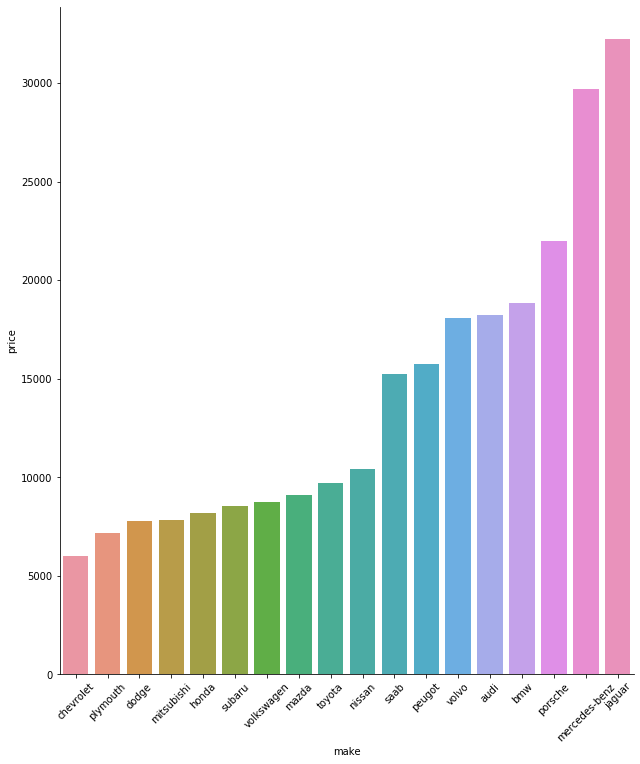

In [6]:
make_group = df.groupby('make')[['make','price']].mean().sort_values(by='price',ascending=True).reset_index()
sns.catplot(x='make',y='price',data=make_group, kind="bar",height=10,aspect=0.9).set_xticklabels(rotation=45)

In [18]:
# Very important result: which car has minimum mpg, it has most expensive price
df.loc[(df.highway_mpg==df.highway_mpg.min()) | (df.city_mpg==df.city_mpg.min())][['make','city_mpg','highway_mpg','price']]

,make,city_mpg,highway_mpg,price
32,jaguar,15,19,32250
48,mercedes-benz,16,18,35056


In [20]:
# Another important result fuel system. Looks like not important, bu if you see first count and last count by price, you could see de differences
df[['price','fuel_system']].sort_values(by='price',ascending=False).head(4)

,price,fuel_system
48,35056,mpfi
32,32250,mpfi
47,31600,idi
45,28248,idi


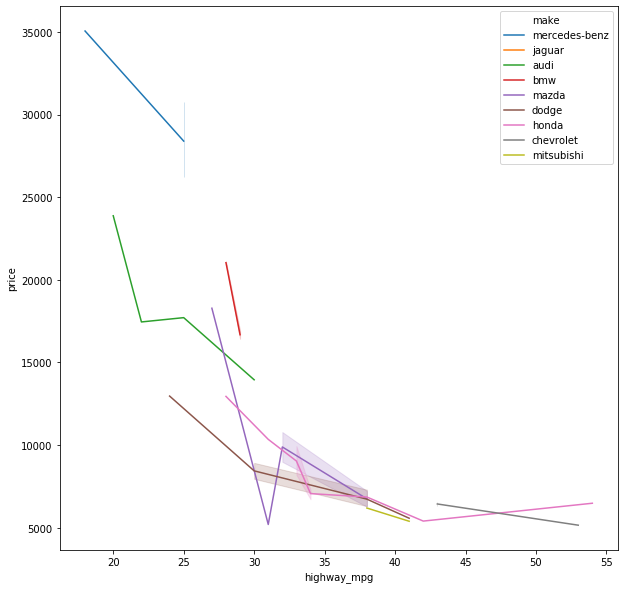

In [7]:
res = df.loc[:50][['make','highway_mpg','price']].sort_values(by='price',ascending=False)
res
plt.figure(figsize=(10,10))
sns.lineplot(x='highway_mpg',y='price',hue='make',data=res)


### I able to much graphic and analyse, but let's go to Regression part

First i create really basic model, give only some integer columns and no changes before

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pandas import DataFrame,Series

# I created function so it was more useful.

def linear_regression(x,y):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=10)
    model = LinearRegression()
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    mse = np.mean((y_test-predict)**2)
    
    #result = pd.DataFrame({'Actual': y_test, 'Predicted': predict})
    #result.plot(kind='bar',figsize=(16,10))
    

    print("Model score : ", model.score(x_test,y_test))
    print("MSE : ",mse)
    coeff = DataFrame(x_train.columns)
    
    coeff['Coef est'] = Series(model.coef_)
    print(coeff.sort_values(by='Coef est',ascending=False))

In [168]:
x = df.loc[:,['wheel_base','curb_weight','engine_size','highway_mpg']]
y= df['price']

linear_regression(x,y)

Model score :  0.8285710606739998
MSE :  5580929.431773531
             0   Coef est
0   wheel_base  86.986891
2  engine_size  57.724754
1  curb_weight   5.917998
3  highway_mpg -70.843305


Not bad for the first time. But needed to develop. We gave only 4 features.

#### Okay, in my opinion "make" column is important because car make affect car price.

In [10]:
car_copy = df.select_dtypes(exclude=['object']).copy()
car_copy['make'] = df['make']
car_copy = pd.get_dummies(car_copy,columns=['make'])
car_copy.corr()['price'].sort_values(ascending=False)

price                 1.000000
curb_weight           0.893639
width                 0.843371
engine_size           0.841496
length                0.760952
wheel_base            0.734419
make_mercedes-benz    0.562170
make_volvo            0.307898
make_jaguar           0.282472
height                0.244836
compression_ratio     0.209361
make_bmw              0.203206
make_audi             0.186448
make_peugot           0.157958
make_porsche          0.143546
make_saab             0.127673
index                 0.034104
make_nissan          -0.062812
make_volkswagen      -0.106364
make_mazda           -0.110073
make_chevrolet       -0.128720
make_subaru          -0.141629
make_dodge           -0.143604
make_plymouth        -0.144733
make_toyota          -0.146905
make_mitsubishi      -0.160617
symboling            -0.162794
make_honda           -0.166074
city_mpg             -0.692273
highway_mpg          -0.720090
Name: price, dtype: float64

### Price column are affected by some "make" columns. 

Model score :  0.9058588914829636
MSE :  3064796.908434403
                     0      Coef est
12            make_bmw  24482.144800
11           make_audi  23649.509066
16         make_jaguar  22248.936727
18  make_mercedes-benz  14917.858365
13      make_chevrolet  12283.234133
14          make_dodge  10761.563028
15          make_honda   9029.964414
17          make_mazda   4523.340756
4                width    393.393051
0                index    232.776845
1            symboling    195.824356
10         highway_mpg     33.916371
6          curb_weight      6.301049
7          engine_size     -1.418161
8    compression_ratio    -29.146693
5               height    -33.358221
9             city_mpg    -43.616797
3               length    -99.286966
2           wheel_base   -126.945047
19     make_mitsubishi  -2795.641512
23        make_porsche  -3791.093869
20         make_nissan  -4339.068368
21         make_peugot  -5111.116525
24           make_saab  -9665.979123
22       make_pl

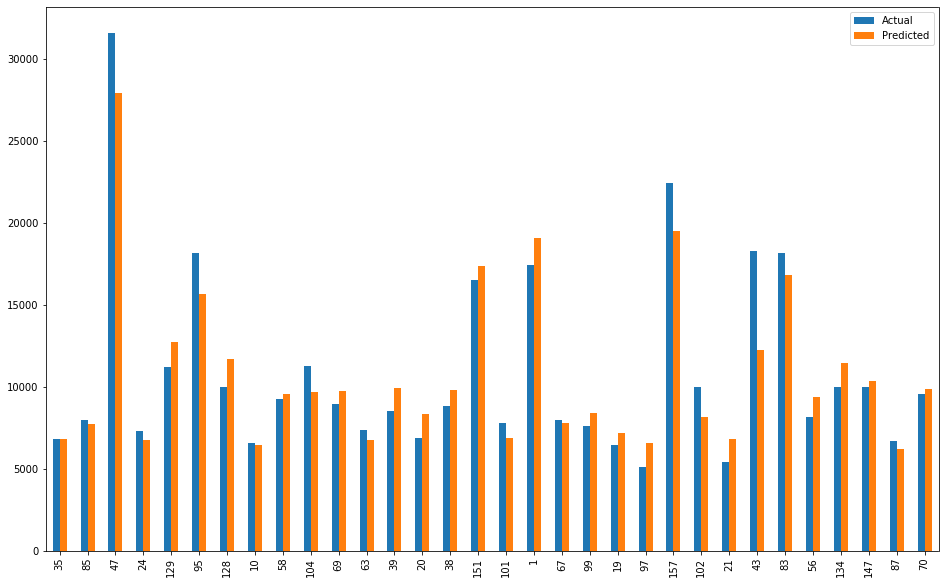

In [11]:
# Lets try regression with new columns.
x,y = car_copy.drop('price',axis=1) , car_copy['price']
linear_regression(x,y)

Woow impressing. I just add 'make' columns (in dummy state). r^2 is going to well, but coef value not well yet.

In [12]:
car_copy['horsepower'] = df['horsepower']
car_copy['horsepower'] = car_copy['horsepower'].astype(int)

In [115]:
#car_copy['log_price'] = np.log(car_copy.price)
#car_copy.rename(columns={'make_mercedes-benz':'make_mercedes_benz'},inplace=True)
y = car_copy['log_price']
x = car_copy.loc[:,['make_bmw','make_audi','make_jaguar','make_chevrolet','make_dodge','make_honda','make_mercedes_benz',
                   'make_mazda','highway_mpg','curb_weight','horsepower','engine_size','wheel_base','city_mpg',
                   'make_mitsubishi','make_nissan','make_porsche','make_peugot','make_saab','make_plymouth','make_subaru',
                   'make_toyota','make_volvo']]
linear_regression(x,y)

Model score :  0.9247606429462951
MSE :  0.01367031579512394
                     0  Coef est
0             make_bmw  0.493181
16        make_porsche  0.467706
6   make_mercedes_benz  0.378625
1            make_audi  0.341341
18           make_saab  0.129957
22          make_volvo  0.118541
2          make_jaguar  0.056714
17         make_peugot  0.044565
5           make_honda  0.032475
8          highway_mpg  0.007831
12          wheel_base  0.005778
7           make_mazda  0.005406
10          horsepower  0.003525
9          curb_weight  0.000464
11         engine_size -0.000014
13            city_mpg -0.008929
3       make_chevrolet -0.017432
21         make_toyota -0.030973
15         make_nissan -0.033656
20         make_subaru -0.055300
4           make_dodge -0.084447
19       make_plymouth -0.127387
14     make_mitsubishi -0.134475


Better coef estimate and as you can see r^2 going to well again! 

### Polynomial Model

In [209]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def polly_reg(x,y):
    
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=12)
    for i in range(4):
        polly = PolynomialFeatures(degree=i)
        x_train_polly = polly.fit_transform(x_train)
    
        model = LinearRegression()
        model.fit(x_train_polly,y_train)
    
        poly_train_pred = model.predict(x_train_polly)
    
        poly_test_predict = model.predict(polly.fit_transform(x_test))
    
        print(f"Train r^2 degree {i}: ",r2_score(poly_train_pred,y_train))
        print(f"Test r^2 degree {i} : ",r2_score(poly_test_predict,y_test))
        

In [210]:
polly_reg(x,y)

Train r^2 degree 0:  -1.0572322755400897e+31
Test r^2 degree 0 :  0.0
Train r^2 degree 1:  0.7777486192895431
Test r^2 degree 1 :  0.7077011986505908
Train r^2 degree 2:  0.871560514125421
Test r^2 degree 2 :  0.6857865053635535
Train r^2 degree 3:  0.9199177223549513
Test r^2 degree 3 :  0.6124708950237667
